## Import Library

In [1]:
import arcpy
import os
import sys
import cv2
import h5py
import numpy as np
import pandas as pd

from scipy.stats import itemfreq
from collections import Counter

from multiprocessing import Pool, freeze_support
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
import gdal

from IPython.display import HTML, display
import tabulate

## 1. Path of Training Data

In [2]:
in_path  = r'D:\land_cover\data\interim'

folder_names  = []
folder_paths  = []

## Get Names of Folders

In [3]:
for folders in os.listdir(in_path):
    folder_names.append(folders)

print(len(folder_names))
print(folder_names)

12
['m_3008718_ne_16_1_20171024', 'm_3008718_nw_16_1_20171024', 'm_3008718_se_16_1_20171024', 'm_3008718_sw_16_1_20171024', 'm_3408601_ne_16_1_20170711', 'm_3408601_nw_16_1_20170711', 'm_3408601_se_16_1_20170711', 'm_3408601_sw_16_1_20170711', 'm_3408602_ne_16_1_20170711', 'm_3408602_nw_16_1_20170711', 'm_3408602_se_16_1_20170711', 'm_3408602_sw_16_1_20170711']


## Get Path of Folders

In [4]:
for folders in os.listdir(in_path):
    folder_paths.append(os.path.join(in_path, folders))

print(len(folder_paths))
print(folder_paths)

12
['D:\\land_cover\\data\\interim\\m_3008718_ne_16_1_20171024', 'D:\\land_cover\\data\\interim\\m_3008718_nw_16_1_20171024', 'D:\\land_cover\\data\\interim\\m_3008718_se_16_1_20171024', 'D:\\land_cover\\data\\interim\\m_3008718_sw_16_1_20171024', 'D:\\land_cover\\data\\interim\\m_3408601_ne_16_1_20170711', 'D:\\land_cover\\data\\interim\\m_3408601_nw_16_1_20170711', 'D:\\land_cover\\data\\interim\\m_3408601_se_16_1_20170711', 'D:\\land_cover\\data\\interim\\m_3408601_sw_16_1_20170711', 'D:\\land_cover\\data\\interim\\m_3408602_ne_16_1_20170711', 'D:\\land_cover\\data\\interim\\m_3408602_nw_16_1_20170711', 'D:\\land_cover\\data\\interim\\m_3408602_se_16_1_20170711', 'D:\\land_cover\\data\\interim\\m_3408602_sw_16_1_20170711']


## 2. Visualize Sample Label Image

D:\land_cover\data\interim\m_3008718_ne_16_1_20171024\labels\000002402.tif
<class 'str'>
{'AREA_OR_POINT': 'Area'}
[ RASTER BAND COUNT ]:  1
<class 'osgeo.gdal.Band'>
[0.0, 5.0, 2.357666015625, 2.2434131714835]
5.0
<class 'numpy.ndarray'>
(256, 256)
(1, 256, 256)


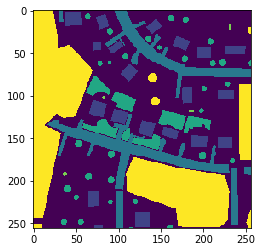

In [5]:
gtif = gdal.Open(r'D:\land_cover\data\interim\m_3008718_ne_16_1_20171024\labels\000002402.tif')
print(r'D:\land_cover\data\interim\m_3008718_ne_16_1_20171024\labels\000002402.tif')
print(type(r'D:\land_cover\data\interim\m_3008718_ne_16_1_20171024\labels\000002402.tif'))
print(gtif.GetMetadata())
print("[ RASTER BAND COUNT ]: ", gtif.RasterCount)
mask = gtif.GetRasterBand(1)
print(type(mask))
print(mask.GetStatistics(True, True))
print(mask.GetStatistics(True, True)[1])
mask = np.array(gtif.GetRasterBand(1).ReadAsArray())
print(type(mask))
print(mask.shape)
mask = np.expand_dims(mask, axis = 0)
print(mask.shape)

f = plt.figure()
plt.imshow(mask[0, :, :])    
plt.show()

## Visualize Sample Input Image

D:\land_cover\data\interim\m_3008718_ne_16_1_20171024\images\000002402.tif
<class 'str'>
{'AREA_OR_POINT': 'Area'}
[ RASTER BAND COUNT ]:  4
<class 'osgeo.gdal.Band'>
[49.0, 236.0, 126.36047363281, 45.567420753765]
<class 'numpy.ndarray'>
(4, 256, 256)


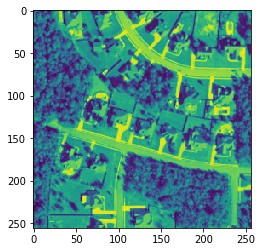

In [6]:
# https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html
gtif = gdal.Open(r'D:\land_cover\data\interim\m_3008718_ne_16_1_20171024\images\000002402.tif')
print(r'D:\land_cover\data\interim\m_3008718_ne_16_1_20171024\images\000002402.tif')
print(type(r'D:\land_cover\data\interim\m_3008718_ne_16_1_20171024\images\000002402.tif'))
print(gtif.GetMetadata())
print("[ RASTER BAND COUNT ]: ", gtif.RasterCount)
image = gtif.GetRasterBand(1)
print(type(image))
print(image.GetStatistics(True, True))
image = np.array(gtif.ReadAsArray())
print(type(image))
print(image.shape)

f = plt.figure()
plt.imshow(image[1, :, :])    
plt.show()

## Land Cover Classes

In [7]:
table = [["Background", 0],
         ["Buildings", 1],
         ["Roads/Parking Lots/Driveways", 2],
         ["Planted/Darker Cropland", 3],
         ["Water", 4],
         ["Forest", 5],
         ["Harvested/Open/Bare", 6]]
display(HTML(tabulate.tabulate(table, tablefmt = 'html')))

Background,0
Buildings,1
Roads/Parking Lots/Driveways,2
Planted/Darker Cropland,3
Water,4
Forest,5
Harvested/Open/Bare,6


## 3. Read Images and Add to List

In [8]:
dark = 0
rgbn = 0

more_50_cover    = 0
less_50_cover    = 0
sample_with_zero = 0
sample_no_zero   = 0

count_lc_class   = []
    
Building  = []
Road      = []
Planted   = []
Water     = []
Forest    = []
Harvested = []

In [9]:
for folders in folder_paths:
    print(folders)
    
    for items in os.listdir((os.path.join(folders, 'labels'))):
        if items.endswith(".tif"):

            output_image_path = os.path.join(os.path.join(folders, 'labels'), items)
            output_image      = gdal.Open(output_image_path)
            output_image_band = output_image.GetRasterBand(1)
            
            if(output_image_band.GetStatistics(True, True)[1] == 0):
                dark = dark + 1
            else:
                label_image    = np.array(output_image.GetRasterBand(1).ReadAsArray())
                unique, counts = np.unique(label_image, return_counts = True)
                freq           = np.asarray((unique, counts)).T
                
                # Check Image is dark or not
                if(0 in unique):
                    sample_with_zero  = sample_with_zero + 1
                    if(freq[numpy.where(unique == 0)[0][0], 1] > 128 * 128 / 2):
                        less_50_cover = less_50_cover + 1
                    else:
                        more_50_cover = more_50_cover + 1
                        
                        # Read TIFF Image
                        input_image_path = output_image_path.replace('labels', 'images')
                        input_image = gdal.Open(input_image_path)
                        input_image = np.array(input_image.ReadAsArray())
                        # print(input_image.shape)
                        
                        # Add New Dim to Label
                        label_image = np.expand_dims(label_image, axis = 0)
                        
                        # Concatenate Image and Mask
                        merge = np.concatenate((input_image, label_image), axis = 0)
                        
                        # Add Image to List
                        if(1 in unique):
                            Building.append(merge)
                        if(2 in unique):
                            Road.append(merge)
                        if(3 in unique):
                            Planted.append(merge)
                        if(4 in unique):
                            Water.append(merge)
                        if(5 in unique):
                            Forest.append(merge)
                        if(6 in unique):
                            Harvested.append(merge)
                        
                        for items in unique:
                            count_lc_class.append(items)
                else:
                    sample_no_zero = sample_no_zero + 1
                        
                    input_image_path = output_image_path.replace('labels', 'images')
                    input_image = gdal.Open(input_image_path)
                    input_image = np.array(input_image.ReadAsArray())
                    # print(input_image.shape)
                    
                    # Add New Dim to Label
                    label_image = np.expand_dims(label_image, axis = 0)

                    # Concatenate Image and Mask
                    merge = np.concatenate((input_image, label_image), axis = 0)

                    # Add Image to List
                    if(1 in unique):
                        Building.append(merge)
                    if(2 in unique):
                        Road.append(merge)
                    if(3 in unique):
                        Water.append(merge)
                    if(4 in unique):
                        Harvested.append(merge)
                    if(5 in unique):
                        Forest.append(merge)
                    if(6 in unique):
                        Planted.append(merge)
                            
                    for items in unique:
                        count_lc_class.append(items)
                            
                rgbn = rgbn + 1

D:\land_cover\data\interim\m_3008718_ne_16_1_20171024
D:\land_cover\data\interim\m_3008718_nw_16_1_20171024
D:\land_cover\data\interim\m_3008718_se_16_1_20171024
D:\land_cover\data\interim\m_3008718_sw_16_1_20171024
D:\land_cover\data\interim\m_3408601_ne_16_1_20170711
D:\land_cover\data\interim\m_3408601_nw_16_1_20170711
D:\land_cover\data\interim\m_3408601_se_16_1_20170711
D:\land_cover\data\interim\m_3408601_sw_16_1_20170711
D:\land_cover\data\interim\m_3408602_ne_16_1_20170711
D:\land_cover\data\interim\m_3408602_nw_16_1_20170711
D:\land_cover\data\interim\m_3408602_se_16_1_20170711
D:\land_cover\data\interim\m_3408602_sw_16_1_20170711


In [10]:
print(dark)
print(rgbn)
print("------------------")
print(sample_with_zero)
print(more_50_cover)
print(less_50_cover)
print("------------------")
print(sample_no_zero)

30840
3032
------------------
3011
351
2660
------------------
21


In [11]:
print('Building:  ', np.array(Building).shape)
print("------------------------------")
print('Road:      ', np.array(Road).shape)
print("------------------------------")
print('Water:     ', np.array(Water).shape)
print("------------------------------")
print('Harvested: ', np.array(Harvested).shape)
print("------------------------------")
print('Forest:    ', np.array(Forest).shape)
print("------------------------------")
print('Planted:   ', np.array(Planted).shape)

Building:   (70, 5, 256, 256)
------------------------------
Road:       (73, 5, 256, 256)
------------------------------
Water:      (117, 5, 256, 256)
------------------------------
Harvested:  (168, 5, 256, 256)
------------------------------
Forest:     (279, 5, 256, 256)
------------------------------
Planted:    (297, 5, 256, 256)


## Land Cover Classes

In [12]:
table = [["Background", 0],
         ["Buildings", 1],
         ["Roads/Parking Lots/Driveways", 2],
         ["Planted/Darker Cropland", 3],
         ["Water", 4],
         ["Forest", 5],
         ["Harvested/Open/Bare", 6]]
display(HTML(tabulate.tabulate(table, tablefmt = 'html')))

Background,0
Buildings,1
Roads/Parking Lots/Driveways,2
Planted/Darker Cropland,3
Water,4
Forest,5
Harvested/Open/Bare,6


## 4. Convert to Numpy

In [13]:
Building_Show = np.array(Building)
print(Building_Show.shape)
print("-------------------------------------")
Road_Show = np.array(Road)
print(Road_Show.shape)
print("-------------------------------------")
Water_Show = np.array(Water)
print(Water_Show.shape)
print("-------------------------------------")
Harvested_Show = np.array(Harvested)
print(Harvested_Show.shape)
print("-------------------------------------")
Forest_Show = np.array(Forest)
print(Forest_Show.shape)
print("-------------------------------------")
Planted_Show = np.array(Planted)
print(Planted_Show.shape)

(70, 5, 256, 256)
-------------------------------------
(73, 5, 256, 256)
-------------------------------------
(117, 5, 256, 256)
-------------------------------------
(168, 5, 256, 256)
-------------------------------------
(279, 5, 256, 256)
-------------------------------------
(297, 5, 256, 256)


## 5. Roll Over Axis

In [14]:
print(Building_Show.shape)
Building_Show = np.rollaxis(Building_Show, 1, 4)
print(Building_Show.shape)
print("-------------------------------------")
print(Road_Show.shape)
Road_Show = np.rollaxis(Road_Show, 1, 4)
print(Road_Show.shape)
print("-------------------------------------")
print(Water_Show.shape)
Water_Show = np.rollaxis(Water_Show, 1, 4)
print(Water_Show.shape)
print("-------------------------------------")
print(Harvested_Show.shape)
Harvested_Show = np.rollaxis(Harvested_Show, 1, 4)
print(Harvested_Show.shape)
print("-------------------------------------")
print(Forest_Show.shape)
Forest_Show = np.rollaxis(Forest_Show, 1, 4)
print(Forest_Show.shape)
print("-------------------------------------")
print(Planted_Show.shape)
Planted_Show = np.rollaxis(Planted_Show, 1, 4)
print(Planted_Show.shape)

(70, 5, 256, 256)
(70, 256, 256, 5)
-------------------------------------
(73, 5, 256, 256)
(73, 256, 256, 5)
-------------------------------------
(117, 5, 256, 256)
(117, 256, 256, 5)
-------------------------------------
(168, 5, 256, 256)
(168, 256, 256, 5)
-------------------------------------
(279, 5, 256, 256)
(279, 256, 256, 5)
-------------------------------------
(297, 5, 256, 256)
(297, 256, 256, 5)


## 6. Separate Image from Label

In [15]:
print(Building_Show.shape)
Building_Image = Building_Show[:, :, :, 0:4]
Building_Label = Building_Show[:, :, :, 4]
Building_Label = np.expand_dims(Building_Label, axis = -1)
print(Building_Image.shape)
print(Building_Label.shape)
print("-------------------------------------")
print(Road_Show.shape)
Road_Image = Road_Show[:, :, :, 0:4]
Road_Label = Road_Show[:, :, :, 4]
Road_Label = np.expand_dims(Road_Label, axis = -1)
print(Road_Image.shape)
print(Road_Label.shape)
print("-------------------------------------")
print(Water_Show.shape)
Water_Image = Water_Show[:, :, :, 0:4]
Water_Label = Water_Show[:, :, :, 4]
Water_Label = np.expand_dims(Water_Label, axis = -1)
print(Water_Image.shape)
print(Water_Label.shape)
print("-------------------------------------")
print(Harvested_Show.shape)
Harvested_Image = Harvested_Show[:, :, :, 0:4]
Harvested_Label = Harvested_Show[:, :, :, 4]
Harvested_Label = np.expand_dims(Harvested_Label, axis = -1)
print(Harvested_Image.shape)
print(Harvested_Label.shape)
print("-------------------------------------")
print(Forest_Show.shape)
Forest_Image = Forest_Show[:, :, :, 0:4]
Forest_Label = Forest_Show[:, :, :, 4]
Forest_Label = np.expand_dims(Forest_Label, axis = -1)
print(Forest_Image.shape)
print(Forest_Label.shape)
print("-------------------------------------")
print(Planted_Show.shape)
Planted_Image = Planted_Show[:, :, :, 0:4]
Planted_Label = Planted_Show[:, :, :, 4]
Planted_Label = np.expand_dims(Planted_Label, axis = -1)
print(Planted_Image.shape)
print(Planted_Label.shape)

(70, 256, 256, 5)
(70, 256, 256, 4)
(70, 256, 256, 1)
-------------------------------------
(73, 256, 256, 5)
(73, 256, 256, 4)
(73, 256, 256, 1)
-------------------------------------
(117, 256, 256, 5)
(117, 256, 256, 4)
(117, 256, 256, 1)
-------------------------------------
(168, 256, 256, 5)
(168, 256, 256, 4)
(168, 256, 256, 1)
-------------------------------------
(279, 256, 256, 5)
(279, 256, 256, 4)
(279, 256, 256, 1)
-------------------------------------
(297, 256, 256, 5)
(297, 256, 256, 4)
(297, 256, 256, 1)


## 7. Normalize Data

In [16]:
Building_Image = np.true_divide(Building_Image, 255)
Building_Image = np.around(Building_Image, decimals = 4)
print(Building_Image.shape)

(70, 256, 256, 4)


In [17]:
Road_Image = np.true_divide(Road_Image, 255)
Road_Image = np.around(Road_Image, decimals = 4)
print(Road_Image.shape)

(73, 256, 256, 4)


In [18]:
Water_Image = np.true_divide(Water_Image, 255)
Water_Image = np.around(Water_Image, decimals = 4)
print(Water_Image.shape)

(117, 256, 256, 4)


In [19]:
Harvested_Image = np.true_divide(Harvested_Image, 255)
Harvested_Image = np.around(Harvested_Image, decimals = 4)
print(Harvested_Image.shape)

(168, 256, 256, 4)


In [20]:
Forest_Image = np.true_divide(Forest_Image, 255)
Forest_Image = np.around(Forest_Image, decimals = 4)
print(Forest_Image.shape)

(279, 256, 256, 4)


In [21]:
Planted_Image = np.true_divide(Planted_Image, 255)
Planted_Image = np.around(Planted_Image, decimals = 4)
print(Planted_Image.shape)

(297, 256, 256, 4)


## 8. Stack Back Label to Image

In [22]:
print(Building_Image.shape)
print(Building_Label.shape)
building = np.concatenate((Building_Image, Building_Label), axis = 3)
print(building.shape)

(70, 256, 256, 4)
(70, 256, 256, 1)
(70, 256, 256, 5)


In [23]:
print(Road_Image.shape)
print(Road_Label.shape)
road = np.concatenate((Road_Image, Road_Label), axis = 3)
print(road.shape)

(73, 256, 256, 4)
(73, 256, 256, 1)
(73, 256, 256, 5)


In [24]:
print(Water_Image.shape)
print(Water_Label.shape)
water = np.concatenate((Water_Image, Water_Label), axis = 3)
print(water.shape)

(117, 256, 256, 4)
(117, 256, 256, 1)
(117, 256, 256, 5)


In [25]:
print(Harvested_Image.shape)
print(Harvested_Label.shape)
harvested = np.concatenate((Harvested_Image, Harvested_Label), axis = 3)
print(harvested.shape)

(168, 256, 256, 4)
(168, 256, 256, 1)
(168, 256, 256, 5)


In [26]:
print(Forest_Image.shape)
print(Forest_Label.shape)
forest = np.concatenate((Forest_Image, Forest_Label), axis = 3)
print(forest.shape)

(279, 256, 256, 4)
(279, 256, 256, 1)
(279, 256, 256, 5)


In [27]:
print(Planted_Image.shape)
print(Planted_Label.shape)
planted = np.concatenate((Planted_Image, Planted_Label), axis = 3)
print(planted.shape)

(297, 256, 256, 4)
(297, 256, 256, 1)
(297, 256, 256, 5)


## 9. Visualize Data

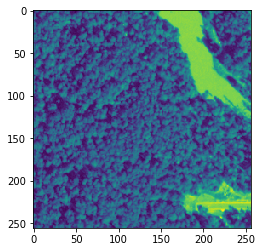

In [28]:
plt.figure()
plt.imshow(road[0, :, :, 0])    
plt.show()

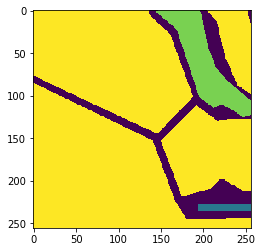

In [29]:
plt.figure()
plt.imshow(road[0, :, :, 4])    
plt.show()

## 10. Convert Labels and Images Numpy to HDF5

In [34]:
Building_hf  = h5py.File(r'D:\land_cover\data\processed\Building.h5', 'w')
Road_hf      = h5py.File(r'D:\land_cover\data\processed\Road.h5', 'w')
Water_hf     = h5py.File(r'D:\land_cover\data\processed\Water.h5', 'w')
Harvested_hf = h5py.File(r'D:\land_cover\data\processed\Harvested.h5', 'w')
Forest_hf    = h5py.File(r'D:\land_cover\data\processed\Forest.h5', 'w')
Planted_hf   = h5py.File(r'D:\land_cover\data\processed\Planted.h5', 'w')

In [35]:
print(building.shape)
Building_hf.create_dataset('Building', data = building)
print(road.shape)
Road_hf.create_dataset('Road', data = road)
print(water.shape)
Water_hf.create_dataset('Water', data = water)
print(harvested.shape)
Harvested_hf.create_dataset('Harvested', data = harvested)
print(forest.shape)
Forest_hf.create_dataset('Forest', data = forest)
print(planted.shape)
Planted_hf.create_dataset('Planted', data = planted)

(70, 256, 256, 5)
(73, 256, 256, 5)
(117, 256, 256, 5)
(168, 256, 256, 5)
(279, 256, 256, 5)
(297, 256, 256, 5)


<HDF5 dataset "Planted": shape (297, 256, 256, 5), type "<f8">

In [36]:
Building_hf.close()
Road_hf.close()
Water_hf.close()
Harvested_hf.close()
Forest_hf.close()
Planted_hf.close()

## 11. Read HDF5 to Double Check

In [41]:
Building = h5py.File(r'.\land_cover\data\processed\Building.h5', 'r')

In [42]:
print(Building.keys())
Image = np.array(Building.get('Building'))
print(Image.shape)

KeysView(<HDF5 file "Building.h5" (mode r)>)
(999, 128, 128, 5)


In [43]:
print(Image[0, 0:5, 0:5, 4])

[[2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]]


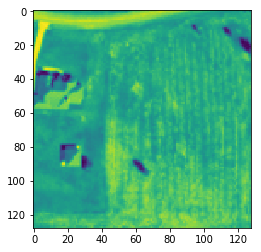

In [44]:
f = plt.figure()
plt.imshow(Image[0, :, :, 0])    
plt.show()

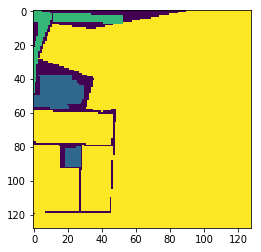

In [45]:
f = plt.figure()
plt.imshow(Image[0, :, :, 4])    
plt.show()

In [46]:
Building.close()